### 1. Importación de librerías

In [1]:
# Importación de librerías
import sys
print(sys.version)

import os


import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer, DistilBertTokenizer, BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, RobertaTokenizer, RobertaModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import random
import io
import pandas as pd
import numpy as np
import uuid

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import SnowballStemmer
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from joblib import dump
import time
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]


### 2. Lectura y filtrado de los datos

In [2]:
def load_data():
    # Leer el archivo y realizar transformaciones en los datos
    df = pd.read_csv("data/BBDD_SeAcabo.csv")
    
    return df



def process_data(df, type_id):

    # Normalize "view_count"
    scaler = StandardScaler()
    df['view_count_scaled'] = scaler.fit_transform(df[['view_count']])

    # User Mentions
    def count_user_mentions(mentions):
        if pd.isna(mentions) or mentions == "":
            return 0
        else:
            return len(mentions.split(';'))
        
    df['mention_count'] = df['user_mentions'].apply(count_user_mentions)

    # Length Tweet
    df['tweet_length'] = df['full_text'].str.len()

    # Num Adjetives
    def count_adjectives(text):
        words = word_tokenize(text)
        pos_tags = pos_tag(words)
        return sum(1 for word, tag in pos_tags if tag.startswith('JJ'))
    df['num_adjectives'] = df['full_text'].apply(count_adjectives)

    #["analisis_general", "contenido_negativo", "insultos"]
    if type_id == "analisis_general":
        # Define the specific labels to keep
        etiquetas = ["Comentario Positivo", "Comentario Negativo", "Comentario Neutro"]


        # Remove NAs
        df = df.dropna(subset=['Análisis General'])
        

        # Factorize the 'Análisis General' column
        labels, labels_names = pd.factorize(df['Análisis General'])

        # 'labels' now contains the numeric representation of your original labels
        # 'label_names' contains the unique values from your original column in the order they were encoded

        # Replace the original column with the numeric labels
        df['label'] = labels

        # If you want to keep a record of the mapping from the original labels to the numeric labels
        label_mapping = dict(zip(labels_names, range(len(labels_names))))
        #print("Label Mapping:", label_mapping)

        n_labels = 3
        label_dict = {'Comentario Positivo': 0, 'Comentario Negativo': 1, 'Comentario Neutro': 2}

    if type_id == "contenido_negativo":

        # Filtrar el DataFrame para seleccionar solo los "Comentario Negativo"
        df = df.loc[df['Análisis General'] == 'Comentario Negativo']

        # Define the specific labels to keep
        etiquetas = ["Desprestigiar Víctima", "Desprestigiar Acto", "Insultos", "Desprestigiar Deportista Autora", "Sexualización / Objetivización", "Estereotipos de Género"]
        df['Contenido Negativo'] = df['Contenido Negativo'].where(df['Contenido Negativo'].isin(etiquetas))

        # Remove NAs
        df = df.dropna(subset=['Contenido Negativo'])
        

        # Factorize the 'Análisis General' column
        labels, labels_names = pd.factorize(df['Contenido Negativo'])

        # 'labels' now contains the numeric representation of your original labels
        # 'label_names' contains the unique values from your original column in the order they were encoded

        # Replace the original column with the numeric labels
        df['label'] = labels

        # If you want to keep a record of the mapping from the original labels to the numeric labels
        label_mapping = dict(zip(labels_names, range(len(labels_names))))
        #print("Label Mapping:", label_mapping)

        n_labels = 6
        label_dict = {'Desprestigiar Acto': 0, 'Desprestigiar Deportista Autora': 1, 'Desprestigiar Víctima': 2, 'Insultos': 3}


    if type_id == "insultos":

        # Filtrar el DataFrame para seleccionar solo los "Comentario Negativo"
        df = df.loc[df['Análisis General'] == 'Comentario Negativo']

        # Define the specific labels to keep
        etiquetas = ["Deseo de Dañar", "Genéricos", "Sexistas/misóginos", ""]

        # Replace labels that are not in the list with "Genéricos"
        df['Insultos'] = df['Insultos'].where(df['Insultos'].isin(etiquetas), other="Genéricos")

        # Remove NAs
        df = df.dropna(subset=['Insultos'])
        

        # Factorize the 'Insultos' column
        labels, labels_names = pd.factorize(df['Insultos'])

        # 'labels' now contains the numeric representation of your original labels
        # 'label_names' contains the unique values from your original column in the order they were encoded

        # Replace the original column with the numeric labels
        df['label'] = labels

        # If you want to keep a record of the mapping from the original labels to the numeric labels
        label_mapping = dict(zip(labels_names, range(len(labels_names))))
        #print("Label Mapping:", label_mapping)

        n_labels = 3
        label_dict = {'Genéricos': 0, 'Sexistas/misóginos': 1, 'Deseo de Dañar': 2}


    # Contar el soporte de cada etiqueta
    soporte_etiquetas = df['label'].value_counts()

    # Imprimir el soporte para cada etiqueta
    print("\nSoporte de etiquetas con nombres originales:")
    for nombre_etiqueta, codigo in label_mapping.items():
        print(f"{nombre_etiqueta}: {soporte_etiquetas[codigo]}")
    
    # Initialize stemmer
    ##stemmer = SnowballStemmer('spanish')
    
    # Define function to remove stopwords, punctuation, and apply stemming
    def remove_spanish_stopwords(text):

        # Eliminar menciones a usuarios (palabras que comienzan con @)
        text = re.sub(r'@\w+', '', text)

        # Eliminar enlaces (todo lo que comienza con http o https)
        #text = re.sub(r'http\S+|https\S+', '', text)

        # Remove punctuation
        text = ''.join([char for char in text if char not in string.punctuation])
        
        # Remove stopwords
        spanish_stopwords = set(stopwords.words('spanish'))
        spanish_stopwords.remove("no")  # Retain "no" as it provides negative context
        words = word_tokenize(text)
        filtered_words = [word.lower() for word in words if word.lower() not in spanish_stopwords]
        
        # Apply stemming (MIRAR)
        ##stemmed_words = [stemmer.stem(word) for word in filtered_words]
        
        ##return ' '.join(stemmed_words)  
        return ' '.join(filtered_words)

    df['full_text_processed'] = df['full_text'].apply(remove_spanish_stopwords)
    # Eliminar filas donde 'full_text_processed' es una cadena vacía
    df = df[df['full_text_processed'] != ""]


    return df, labels_names, n_labels, label_dict

type_id = "analisis_general" #["analisis_general", "contenido_negativo", "insultos"]
df = load_data()
df, labels_names, n_labels, label_dict = process_data(df, type_id)
df


Soporte de etiquetas con nombres originales:
Comentario Positivo: 2117
Comentario Neutro: 120
Comentario Negativo: 435


,Autora,full_text,Análisis General,Contenido Negativo,Insultos,Insulto 1,Insulto 2,Insulto 3,Emisor,Contenido AV.,...,profile_url,avatar_url,verified,is_blue_verified,view_count_scaled,mention_count,tweet_length,num_adjectives,label,full_text_processed
0,Jenni Hermoso,@Jennihermoso TODA ESPAÑA ESTÁ CONTIGO https:/...,Comentario Positivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,https://www.twitter.com/Araujismoo,https://pbs.twimg.com/profile_images/167886449...,False,True,14.236127,1,62,1,0,toda españa contigo httpstcocgw7wwfpzi
1,Jenni Hermoso,@Jennihermoso Espero que te llegue todo el arr...,Comentario Positivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,https://www.twitter.com/ionebelarra,https://pbs.twimg.com/profile_images/160626561...,False,False,12.886237,1,113,3,0,espero llegue arrope queremos transmitirte adm...
2,Jenni Hermoso,@Jennihermoso No estás sola💜,Comentario Positivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,https://www.twitter.com/carlagaleote,https://pbs.twimg.com/profile_images/161793790...,False,False,12.438174,1,28,1,0,no sola💜
3,Jenni Hermoso,@Araujismoo @Jennihermoso She’s a legend .,Comentario Positivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,https://www.twitter.com/emmaltrix,https://pbs.twimg.com/profile_images/169070741...,False,True,7.259182,2,42,1,0,she ’ s legend
4,Jenni Hermoso,"@Jennihermoso Dilo, reina https://t.co/GasZHE70bE",Comentario Positivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,https://www.twitter.com/TirodeGraciah,https://pbs.twimg.com/profile_images/163890386...,False,True,7.113684,1,49,1,0,dilo reina httpstcogaszhe70be
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,Eva Navarro,@evaaanavarro @Paulaa_311 @Jennihermoso 💜💪🏽,Comentario Positivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,https://www.twitter.com/sandrus260,https://pbs.twimg.com/profile_images/166507079...,False,False,-0.254662,3,43,1,0,💜💪🏽
2668,Eva Navarro,@evaaanavarro @Jennihermoso Z https://t.co/9vH...,Comentario Positivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,https://www.twitter.com/Giorgio7716,https://pbs.twimg.com/profile_images/164212369...,False,False,-0.265724,2,53,1,0,z httpstco9vh1vggz1h
2669,Eva Navarro,@evaaanavarro @Jennihermoso Doblemente campeon...,Comentario Positivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,https://www.twitter.com/framarub,https://pbs.twimg.com/profile_images/125216679...,False,False,-0.273240,2,73,1,0,doblemente campeona
2670,Eva Navarro,@evaaanavarro @Jennihermoso Brava!! Siempre co...,Comentario Positivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,https://www.twitter.com/Joannacolomer,https://pbs.twimg.com/profile_images/140020219...,False,False,-0.279278,2,72,1,0,brava siempre campeonas 🏆🏅💜


### 3. Definición del modelo y entrenamiento

In [3]:
# Tokenización y codificación de los datos

#tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#model = BertModel.from_pretrained("bert-base-cased")

#tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
#model = BertModel.from_pretrained("bert-large-cased")

#tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased') #beto
#model = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased") #beto

#tokenizer = RobertaTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-bne') 
#model = RobertaModel.from_pretrained("PlanTL-GOB-ES/roberta-base-bne") 

tokenizer = RobertaTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-large-bne') 
model = RobertaModel.from_pretrained("PlanTL-GOB-ES/roberta-large-bne") 

#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
#model = BertModel.from_pretrained("bert-base-multilingual-cased")


c:\Users\jorge\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Hiperparámetros del modelo
BATCH_SIZE = 16  # [16,32,64]
MAX_SEQUENCE = 256 # [128, 256, 512]
LEARNING_RATE = 2e-5 # [1e-4, 5e-5, 1e-5]
EPOCH = 10 # [10, 15, 20]

# División de datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(df['full_text_processed'], 
                                                  df['label'], 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=df['label'])
df.loc[X_train.index, 'data_type'] = 'train'
df.loc[X_val.index, 'data_type'] = 'val'
df.groupby(['label', 'data_type']).count()

# Prepara los datos para el entrenamiento y validación
encoded_data_train = tokenizer.batch_encode_plus( 
    df[df.data_type=='train']['full_text_processed'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    truncation=True,
    max_length=MAX_SEQUENCE, 
    return_tensors='pt'
)
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val']['full_text_processed'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    truncation=True,
    max_length=MAX_SEQUENCE,
    return_tensors='pt'
)
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train']['label'].values)
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val']['label'].values)
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

# Configuración del dispositivo (GPU o CPU) y congelación de parámetros del modelo base
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

for name, param in model.named_parameters():
    print(name)

for name, param in list(model.named_parameters()):#[:-20]:
    print('I will be frozen: {}'.format(name))
    param.requires_grad = False



# Definición de la arquitectura del modelo de clasificación
class ROBERTAClass(torch.nn.Module):
    def __init__(self):
        super(ROBERTAClass, self).__init__()
        self.l1 = model
        self.pre_classifier = torch.nn.Linear(1024, 264) # roberta large 1024, roberta base 768
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(264, n_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.l1(input_ids=input_ids, attention_mask=attention_mask)

        # Use the pooled output (the second element of the outputs tuple) for classification
        # This is typically what you want for a classification task.
        pooler_output = outputs[1]

        pooler_output = self.pre_classifier(pooler_output)
        pooler_output = torch.nn.ReLU()(pooler_output)
        pooler_output = self.dropout(pooler_output)
        output = self.classifier(pooler_output)
        return output

# Instanciación y configuración del modelo
model = ROBERTAClass()
model.to(device)

print(model)

# Configuración de los dataloaders y optimizador
batch_size = BATCH_SIZE
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
epochs = EPOCH
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

# Definición de funciones para evaluación y métricas
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

# Semilla para reproducibilidad
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Cálculo de los pesos de clase
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train.numpy())
weights = torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

# Definición de la función de pérdida con pesos de clase
def weighted_cross_entropy(outputs, targets):
    return torch.nn.CrossEntropyLoss(weight=weights)(outputs, targets)

def evaluate(dataloader_val):
    model.eval()  # Set model to evaluation mode
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1]
        }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = weighted_cross_entropy(outputs, batch[2])
        loss_val_total += loss.item()

        # Append predictions and true values for later evaluation
        predictions.append(outputs.detach().cpu().numpy())
        true_vals.append(batch[2].cpu().numpy())

    # Calculate average loss over all batches
    loss_val_avg = loss_val_total / len(dataloader_val)

    # Concatenate all batches
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    # Convert predictions to labels
    preds_flat = np.argmax(predictions, axis=1).flatten()

    # Calcular la matriz de confusión
    cm = confusion_matrix(true_vals.flatten(), preds_flat)

    # Opcional: Visualizar la matriz de confusión
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues")
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Etiquetas Verdaderas')
    ax.set_title('Matriz de Confusión')
    plt.show()

    # Retorna la pérdida promedio, predicciones, etiquetas verdaderas, y la matriz de confusión
    return loss_val_avg, predictions, true_vals, cm


C:\Users\jorge\AppData\Local\Temp\ipykernel_20652\2410103966.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[X_train.index, 'data_type'] = 'train'


cpu
embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.layer.1.attention.self

c:\Users\jorge\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/10 [32:27<?, ?it/s]


Epoch 1
Training loss: 1.0841427233183023


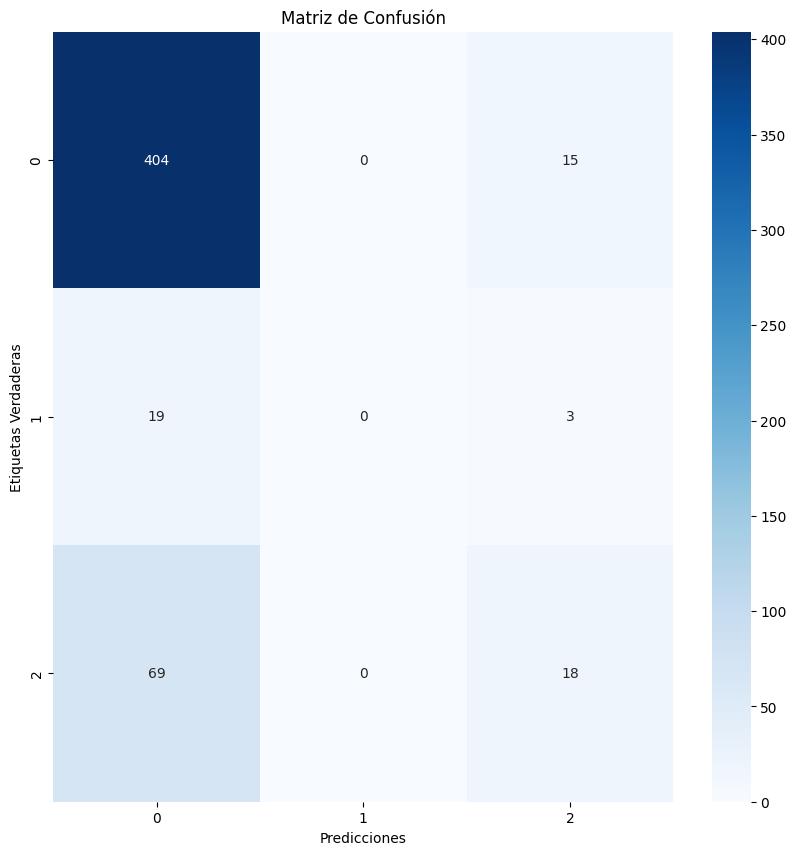

 10%|█         | 1/10 [34:16<5:08:25, 2056.13s/it]

Validation loss: 1.0524518002163281
F1 Score (Weighted): 0.7520647696747399


 10%|█         | 1/10 [1:07:08<5:08:25, 2056.13s/it]


Epoch 2
Training loss: 1.0697261930415125


 10%|█         | 1/10 [1:09:00<10:21:04, 4140.53s/it]


TypeError: 'numpy.ndarray' object is not callable

In [5]:
from tqdm import tqdm

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:
        batch = tuple(b.to(device) for b in batch)
        
        # Reset the gradients from the previous iteration
        model.zero_grad()

        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1]
        }

        outputs = model(**inputs)
        #logits = outputs.logits
        loss = weighted_cross_entropy(outputs, batch[2])
        loss_train_total += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    torch.save(model.state_dict(), f'roberta-base-bne/finetuned_roberta-base-bne_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    val_loss, predictions, true_vals, confusion_matrix = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


### 4. Evaluación del modelo en el conjunto de validación

In [ ]:
# Evaluación en el conjunto de validación
_, predictions, true_vals = evaluate(dataloader_validation)

# Manipulación de predicciones y creación del csv
tensor_pred = torch.from_numpy(predictions)
softmax = torch.nn.Softmax(dim=1)
softmax(tensor_pred)
df_predictions = pd.DataFrame(columns = ["full_text_processed", "True Rating", "Predicted Rating", "Pred Prob 0", "Pred Prob 1", "Pred Prob 2"])
df_predictions["full_text_processed"] = df[df.data_type=='val']['full_text_processed'].copy().reset_index(drop = True)
df_predictions["True Rating"] = df[df.data_type=='val']['label'].reset_index(drop = True).copy()
df_predictions["Predicted Rating"] = np.argmax(predictions, axis=1)
df_predictions[["Pred Prob 0", "Pred Prob 1", "Pred Prob 2"]] = list(softmax(tensor_pred).numpy())
df_predictions.to_csv('df_predictions.csv', encoding = 'utf8')
df_predictions.to_excel('df_prediction.xlsx')
val_f1 = f1_score_func(predictions, true_vals)
acc = accuracy_per_class(predictions, true_vals)